In [1]:
!pip install prophet

In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np


In [45]:
data = pd.read_csv('merged_df.csv')
df = data.rename(columns={"Data": "ds", "value": "y"})
df["ds"] = pd.to_datetime(df["ds"])

train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [21]:
df.ds.isnull().sum()

0

C:\Users\micha\AppData\Local\Temp\ipykernel_31908\542872357.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decompose.plot().show()


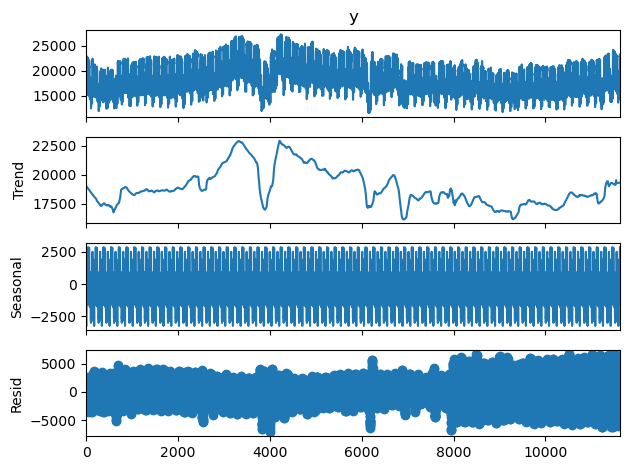

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(train.y, model='additive', extrapolate_trend='freq', period=168)

decompose.plot().show()

In [47]:

from prophet.make_holidays import make_holidays_df

holidays = make_holidays_df(year_list=[2023, 2024,2025], country="PL")

model = Prophet(holidays=holidays)
model.add_seasonality(name='daily', period=24, fourier_order=15)  # Daily seasonality (24 hours)
model.add_seasonality(name='weekly', period=24*7, fourier_order=20)  # Weekly seasonality (24*7 hours)

# Trenowanie modelu na danych
model.fit(train)

10:32:53 - cmdstanpy - INFO - Chain [1] start processing
10:32:56 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
# Tworzymy przyszłe daty dla okresów godzinowych
future = model.make_future_dataframe(periods=len(test), freq='H')

# Generujemy prognozę
forecast = model.predict(future)

c:\Users\micha\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [49]:
# Pobieramy tylko te prognozy, które odpowiadają testowym danym
forecast_test = forecast.iloc[-len(test):]  # Ostatnie n prognoz

# Obliczamy MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test["y"].values, forecast_test["yhat"].values)
print(f"MAPE: {mape:.2f}%")

MAPE: 13.61%


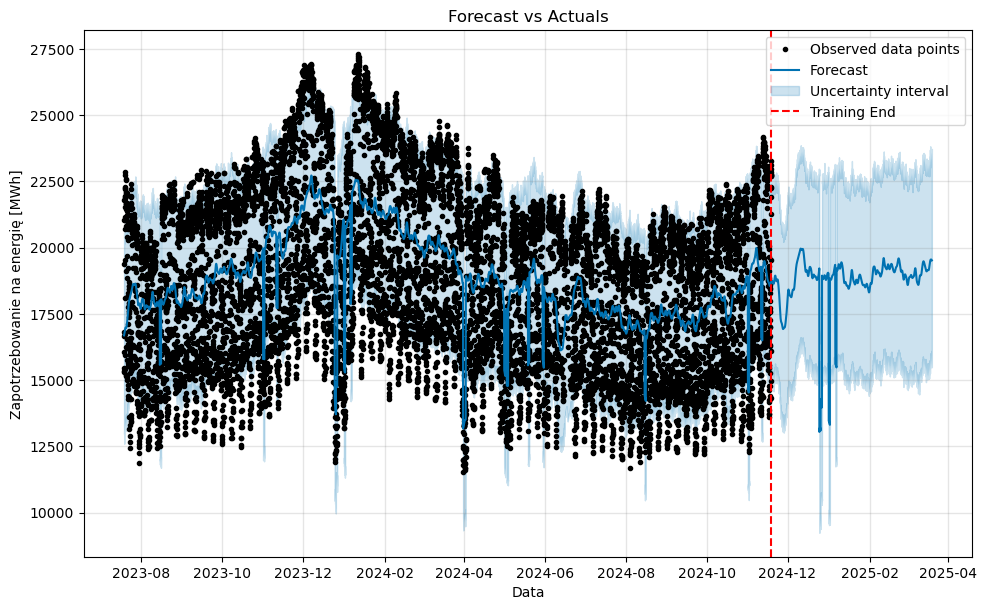

In [66]:
import matplotlib.pyplot as plt

# plot the time series without observed data points
forecast_plot = model.plot(forecast, include_legend=False)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast['ds'].iloc[-len(test)]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')
axes.set_title('Forecast vs Actuals')
axes.set_xlabel('Data')
axes.set_ylabel('Zapotrzebowanie na energię [MWh]')
plt.legend()

Text(65.34722222222221, 0.5, 'Zapotrzebowanie na energię [MWh]')

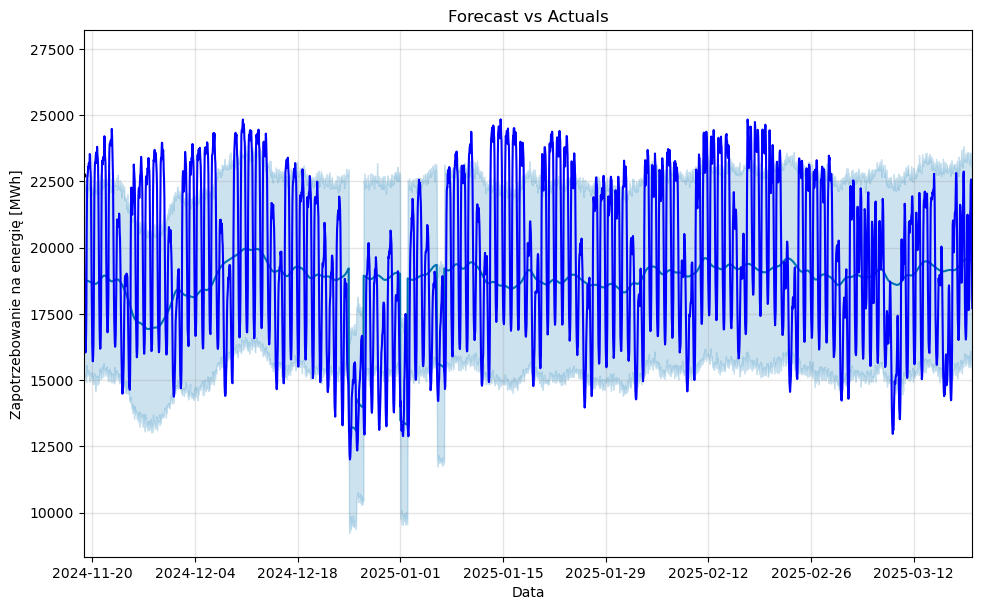

In [65]:
import matplotlib.pyplot as plt

# plot the time series without observed data points
forecast_plot = model.plot(forecast_test, include_legend=False)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast['ds'].iloc[-len(test)]
axes.set_title('Forecast vs Actuals')
plt.plot(test["ds"], test["y"], label='Actual', color='blue')
axes.set_xlim(left=test["ds"].iloc[0], right=test["ds"].iloc[-1])
axes.set_xlabel('Data')
axes.set_ylabel('Zapotrzebowanie na energię [MWh]')